In [2]:
# Install dependencies
! pip install ta
! pip install tensorflow
! pip install keras

In [17]:
# Libraries for Data Analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import timedelta

# Machine learning Library
from sklearn.preprocessing import RobustScaler

# Library for Performing Technical Analysis
import ta

# Tensorflow 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Loading the data
data_frame = pd.read_csv("SPY_historical_data.csv")

In [18]:
data_frame['Date'] = pd.to_datetime(data_frame.Date)
data_frame.set_index('Date', inplace=True)
data_frame.dropna(inplace=True)

data_frame = ta.add_all_ta_features(data_frame, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

data_frame.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis = 1, inplace = True)

data_frame = data_frame.tail(1000)

close_scaler = RobustScaler()

close_scaler.fit(data_frame[['Close']])

scaler = RobustScaler()

data_frame = pd.DataFrame(scaler.fit_transform(data_frame), columns = data_frame.columns, index = data_frame.index)

C:\Users\AndrejsinD\Anaconda3\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\Users\AndrejsinD\Anaconda3\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [31]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
  

def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          
            
def validator(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=data_frame.index, columns=[data_frame.columns[0]])

    for i in range(n_per_in, len(data_frame)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = data_frame[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [32]:
days_learn = 90

days_predict = 30

features = data_frame.shape[1]

x,y = split_sequence(data_frame.to_numpy(), days_learn, days_predict)

In [ ]:
model = Sequential()

activ = "tanh"

model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(days_learn, features)))

layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)

model.add(LSTM(60, activation=activ))

model.add(Dense(days_predict))

model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

res = model.fit(x, y, epochs=100, batch_size=128, validation_split=0.1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 90, 90)            59040     
_________________________________________________________________
lstm_13 (LSTM)               (None, 90, 30)            14520     
_________________________________________________________________
lstm_14 (LSTM)               (None, 60)                21840     
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1830      
Total params: 97,230
Trainable params: 97,230
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 12s 2s/step - loss: 0.2445 - accuracy: 0.0215 - val_loss: 0.5852 - val_accuracy: 0.0449
Epoch 2/100
7/7 [==============================] - 7s 935ms/step - loss: 0.1448 - accuracy: 0.0164 - val_loss

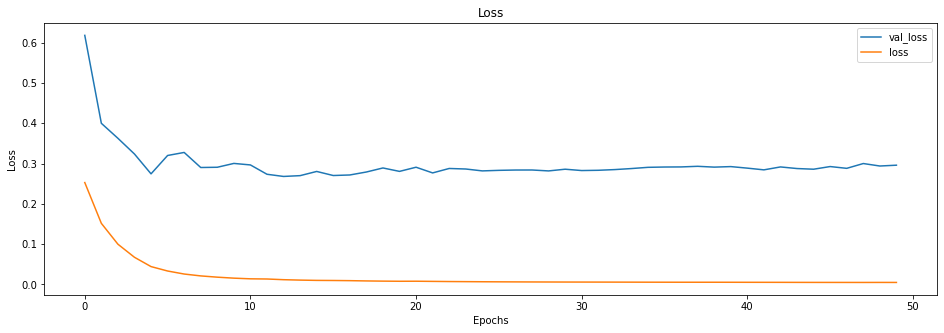

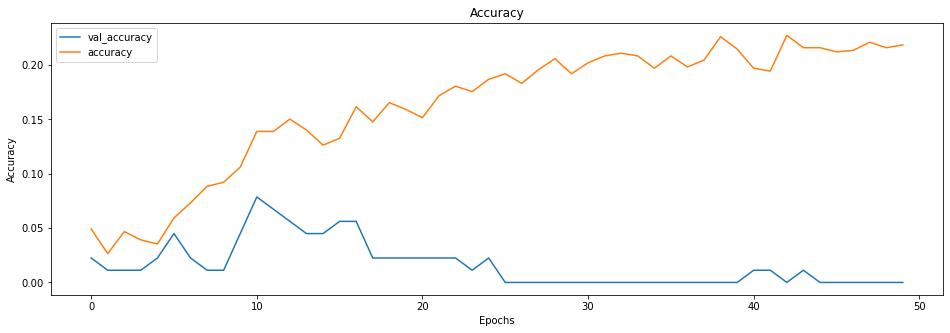

In [25]:
visualize_training_results(res)

In [27]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(data_frame[["Close"]]), 
                      index=data_frame.index, 
                      columns=[data_frame.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(days_learn, days_predict)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.xlim('2018-05', '2020-05')
plt.show()

NameError: name 'df' is not defined